In this project, I will use autoencoders to detect credit card fraud. 
Reason for doing this project is that I read a report suggesting credit card fraud has been approximated at around 9 billion and expected to grow. The ability to use algorithms to detect fraud becomes imperative for companies wanting to thrive in this industry.

Autoencoders is a newer technology to detect fraud and companies like Paypal use complex models of this in their own system. These are a type of neural network that take an input, and try to circle in to the key features of the input. Using these key features, it tries to recreate the original input. The ability to determine these key features in an unsupervised manner make the autoencoders powerful. This project is my attempt to test out just how good it is on a real dataset. 


In [1]:
# Importing the packages 
import numpy as np 
import pandas as pd 
from scipy import stats 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, classification_report, auc, roc_curve, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model 
from keras.layers import Input, Dense 
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
print("Imported all packages")


C:\Users\llaho\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Imported all packages


In [2]:
# Read in the data in a dataframe and a few checks to make sure data is okay
df = pd.read_csv("creditcard.csv")
df.head()
df.shape   # (284807, 31)
df.isnull().values.any()  # No empty values

False

In [3]:
# To get an idea of the bias in the dataset, a good idea is to check the counts of the class variables present
pd.value_counts(df["Class"])

0    284315
1       492
Name: Class, dtype: int64

Checking the dataset, I can see that the data is highly biased towards non-fraudulent transactions, which is the norm in these kinds of datasets. Now to explore the data by separating into specific classes. 

In [4]:
non_fraud = df[df["Class"] == 0]
fraud = df[df["Class"] ==1]
non_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


In [5]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


The amount of the fraudulent transactions is marked at ~ 122 whereas the non fraudulent transactions have a mean of ~ 88. There is slight variations in the standard deviations as well. This data is better understood by visually plotting it. I will plot the percentage of fraudulent or non-fraudulent transactions for the high amount transactions ( >200$).  

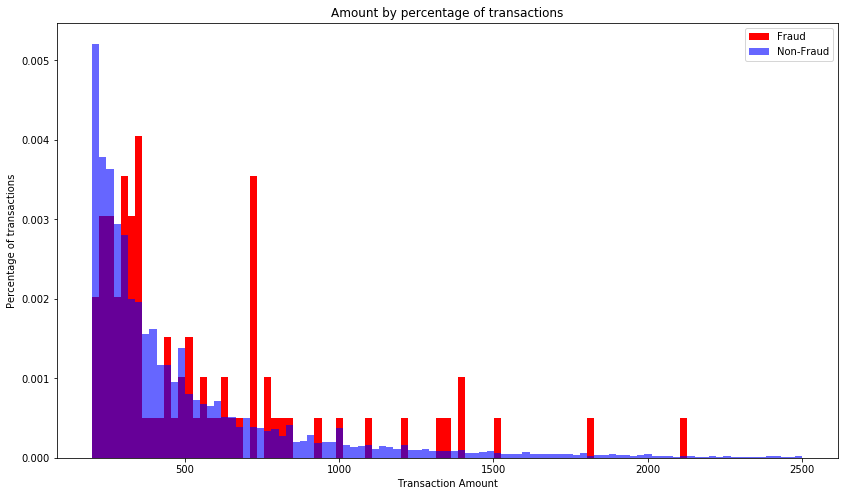

In [6]:
bins = np.linspace(200,2500,100)

fraud_amount = fraud["Amount"]
non_fraud_amount = non_fraud["Amount"]

rcParams['figure.figsize'] = 14, 8
plt.hist(fraud_amount, bins, density = True, alpha = 1.0, color= 'red', label = "Fraud")
plt.hist(non_fraud_amount, bins, density = True, alpha = 0.6, color= 'blue', label = "Non-Fraud")
plt.legend(loc = 'upper right')
plt.xlabel("Transaction Amount")
plt.ylabel("Percentage of transactions")
plt.title("Amount by percentage of transactions")

plt.show()


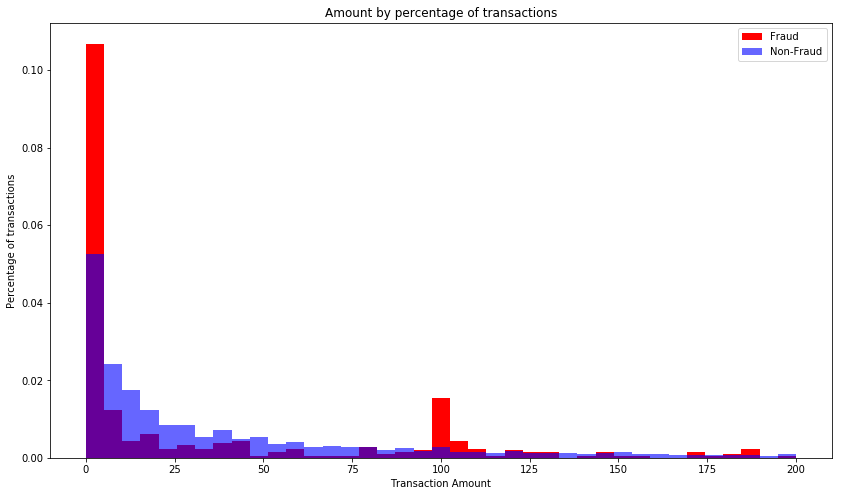

In [7]:
# Now for the lower transactions
bins = np.linspace(0,200,40)

rcParams['figure.figsize'] = 14, 8
plt.hist(fraud_amount, bins, density = True, alpha = 1.0, color= 'red', label = "Fraud")
plt.hist(non_fraud_amount, bins, density = True, alpha = 0.6, color= 'blue', label = "Non-Fraud")
plt.legend(loc = 'upper right')
plt.xlabel("Transaction Amount")
plt.ylabel("Percentage of transactions")
plt.title("Amount by percentage of transactions")

plt.show()


Both the graphs follow the same trend in terms of being concentrated around the same values. This is not enough to discriminate between the two and we will need more indicators. I'll plot a few other values to see if they show any trends. 

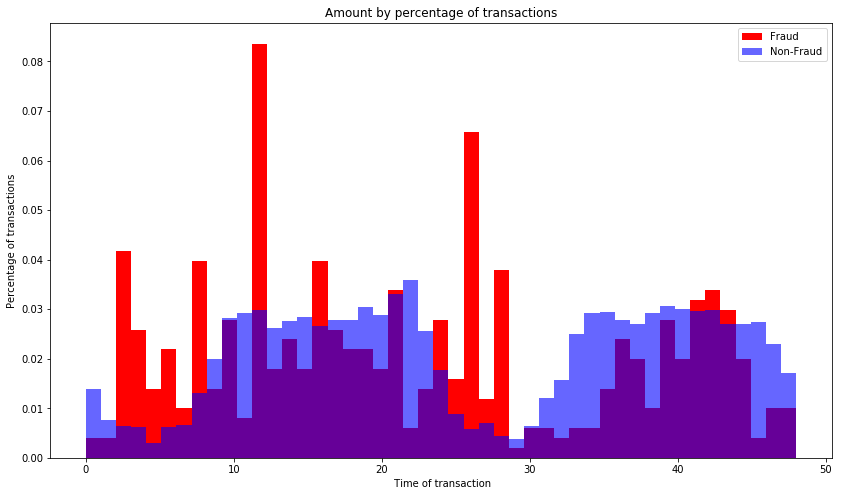

In [8]:
# Plotting the time of the day. 
fraud_time = [i/(60*60) for i in fraud["Time"]]
non_fraud_time = [i/(60*60) for i in non_fraud["Time"]]

bins = np.linspace(0,48,48)   # Corresponding to 48 hours

rcParams['figure.figsize'] = 14, 8
plt.hist(fraud_time, bins, density = True, alpha = 1.0, color= 'red', label = "Fraud")
plt.hist(non_fraud_time, bins, density = True, alpha = 0.6, color= 'blue', label = "Non-Fraud")
plt.legend(loc = 'upper right')
plt.xlabel(" Time of transaction")
plt.ylabel("Percentage of transactions")
plt.title("Amount by percentage of transactions")

plt.show()

From this graph, I can see that majority of the fraudulent transaction tend to happen close to late at night, which also correspond to a decrease in a non-fraudulent transactions. But the trend is not general enough to differentiate the two and I'll need to check other things. I'll see what I get if I plot transaction amount v/s time of the day. 

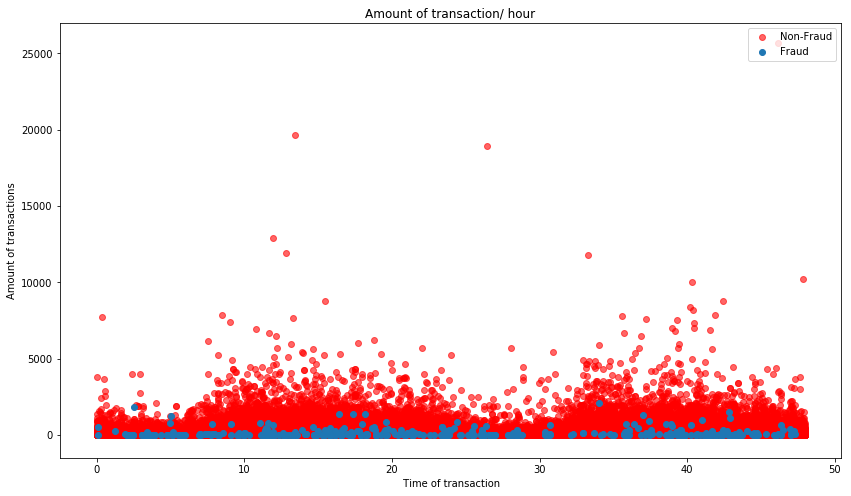

In [9]:
rcParams['figure.figsize'] = 14, 8
plt.scatter(non_fraud_time, non_fraud_amount, alpha = 0.6, label = "Non-Fraud", color = 'red')
plt.scatter(fraud_time, fraud_amount, alpha = 1.0, label = "Fraud")
plt.legend(loc = 'upper right')
plt.xlabel(" Time of transaction")
plt.ylabel("Amount of transactions")
plt.title("Amount of transaction/ hour")
plt.show()

This graph also does not give me a lot of information about any clear divisions between fraudulent and non-fraudulent transactions as there is no line that I can draw which separates the two colored dots cleanly. Since exploring the data is not proving to be useful, I will use an autoencoder to check. The first step is to normalize the data. 

In [10]:
normalized_df = df 

# StandardScaler converts the given column into a mean = 0, std = 1 dataset
normalized_df["Time"] = StandardScaler().fit_transform(normalized_df["Time"].values.reshape(-1,1))  
normalized_df["Amount"] = StandardScaler().fit_transform(normalized_df["Amount"].values.reshape(-1,1)) 
normalized_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [35]:
# Split the dataset into training and testing sets

x_train , x_test = train_test_split(normalized_df, test_size = 0.2)
x_train = x_train[x_train["Class"] == 0]   # Select the ones which have non-fraudulent class indicator for training
x_train.drop(["Class"], axis = 1, inplace = True)

In [36]:
y_test = x_test['Class']
x_test.drop(["Class"], inplace = True, axis = 1)

x_train = x_train.values
x_test = x_test.values

C:\Users\llaho\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [37]:
x_train.shape
x_test.shape


(56962, 30)

To create the model, there are few things to keep in mind. The choice of how dense the layers in the autoencoder will be determined by hyperparameter tuning. I am encoding 30 columns into 15 columns and the hidden layer to have floor(15/2) = 7 layers. For the learning rate, epochs, batch size, learning policy and activation filter, I will choose some generic values. 

In [38]:
epoch = 100
batch_size = 128
input_dimension = 30 
encoded_dimension = 15
hidden_dimension = 7 
learning_rate = 1e-7 


input_layer = Input(shape = (input_dimension, ))

# tanh activation ranges between [-1,1], l1 is lasso regression which shrinks the weights of unimportant features to 0. 

encoder_1 = Dense(encoded_dimension, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder_2 = Dense(hidden_dimension, activation = 'relu')(encoder_1)
decoder_1 = Dense(hidden_dimension, activation = 'tanh')(encoder_2)
decoder_2 = Dense(input_dimension, activation = 'relu')(decoder_1)
autoencoder = Model(inputs = input_layer, outputs = decoder_2)

# Setting up the autoencoder. Adam optimizer can be used instead of stochastic gradient descent to update weights

autoencoder.compile(metrics = ['accuracy'], loss = 'mean_squared_error', optimizer = 'adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir = './logs', histogram_freq = 0, write_graph = True, write_images = True)

history = autoencoder.fit(x_train, x_train ,epochs=epoch, batch_size=batch_size, shuffle=True,
                        validation_data=(x_test, x_test), verbose=1,callbacks=[cp, tb]).history




Train on 227455 samples, validate on 56962 samples
Epoch 1/100
227455/227455 [==============================] - 5s 23us/step - loss: 0.8654 - acc: 0.4362 - val_loss: 0.8284 - val_acc: 0.5719
Epoch 2/100
227455/227455 [==============================] - 5s 22us/step - loss: 0.7728 - acc: 0.6114 - val_loss: 0.7882 - val_acc: 0.6464
Epoch 3/100
227455/227455 [==============================] - 5s 22us/step - loss: 0.7435 - acc: 0.6542 - val_loss: 0.7700 - val_acc: 0.6567
Epoch 4/100
227455/227455 [==============================] - 5s 22us/step - loss: 0.7307 - acc: 0.6611 - val_loss: 0.7618 - val_acc: 0.6621
Epoch 5/100
227455/227455 [==============================] - 6s 26us/step - loss: 0.7220 - acc: 0.6728 - val_loss: 0.7532 - val_acc: 0.6741
Epoch 6/100
227455/227455 [==============================] - 4s 16us/step - loss: 0.7169 - acc: 0.6799 - val_loss: 0.7488 - val_acc: 0.6796
Epoch 7/100
227455/227455 [==============================] - 5s 20us/step - loss: 0.7136 - acc: 0.6858 - val_

Epoch 59/100
227455/227455 [==============================] - 8s 34us/step - loss: 0.6930 - acc: 0.7072 - val_loss: 0.7303 - val_acc: 0.7101
Epoch 60/100
227455/227455 [==============================] - 7s 29us/step - loss: 0.6926 - acc: 0.7082 - val_loss: 0.7301 - val_acc: 0.7096
Epoch 61/100
227455/227455 [==============================] - 8s 35us/step - loss: 0.6931 - acc: 0.7070 - val_loss: 0.7296 - val_acc: 0.7060
Epoch 62/100
227455/227455 [==============================] - 9s 37us/step - loss: 0.6925 - acc: 0.7083 - val_loss: 0.7297 - val_acc: 0.7123
Epoch 63/100
227455/227455 [==============================] - 7s 33us/step - loss: 0.6923 - acc: 0.7086 - val_loss: 0.7411 - val_acc: 0.6912
Epoch 64/100
227455/227455 [==============================] - 5s 22us/step - loss: 0.6929 - acc: 0.7094 - val_loss: 0.7298 - val_acc: 0.7115
Epoch 65/100
227455/227455 [==============================] - 6s 25us/step - loss: 0.6917 - acc: 0.7099 - val_loss: 0.7292 - val_acc: 0.7065
Epoch 66/100


One source of error here is the learning rate. Initially, I had a learning rate of 1e-3 which resulted in a very low accuracy. I decreased it a few times and I seem to be getting the best results with the current learning rate of 1e-7. 

Now to evaluate the model, I will make some basic plots to show how the model did over time. 

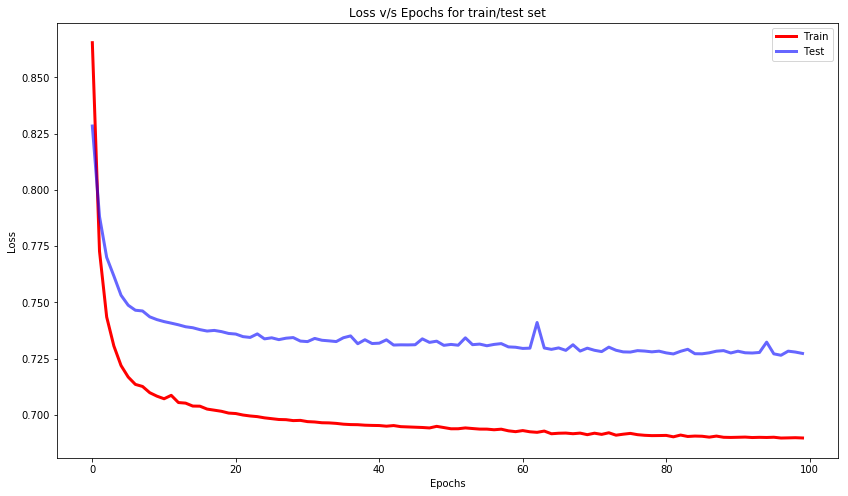

In [39]:
plt.plot(history["loss"], linewidth = 3, color = 'red', label = 'Train')
plt.plot(history["val_loss"], linewidth = 3, alpha = 0.6, color = 'blue', label = 'Test')
plt.legend(loc = 'upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epochs for train/test set")
plt.show()

I can see the training loss value is much lower than the testing loss values so one thing I know is that the model is not generalized enough. However, the good thing is that the losses decrease over time hence the autoencoder was able to identify some correct features and able to recreate fraudulent and non fraudulent transactions. Now I want to check for reconstruction error. 

In [48]:
from sklearn.metrics import mean_squared_error
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions,2), axis = 1)
error_df = pd.DataFrame({"Reconstruction_error" : mse,
                        "True_value" : y_test})
error_df.describe()


,Reconstruction_error,True_value
count,56962.000000,56962.000000
mean,0.727219,0.001791
std,3.154281,0.042279
min,0.047372,0.000000
25%,0.243728,0.000000
50%,0.401274,0.000000
75%,0.627466,0.000000
max,270.344860,1.000000


There are a few definitions that one needs to eb clear on before proceesing. 

ROC curve is a probability measure by plotting True Positive Rate against the False Positive Rate. TPR is the proportion of actual positives that are correctly identified. FPR is the ratio of number of negative events wrongly classified as positive events and the total number of negatives. The area under the ROC curve is the measure of accuracy of the model. 

AUC measures the degree of separability of the classes. If the AUC values is 0.7, that measn there's a 70% chance of making a distinction between the two classes. 

Precision is the number of results which are relevant. TP/(TP + FP) 

Recall refers to the percentage of total relevant reuslts classified correctly by algorithm. TP/(TP + FN) 



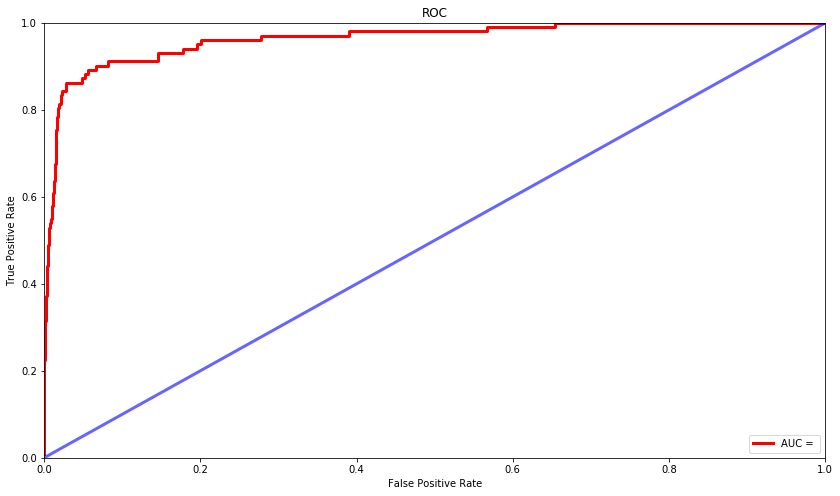

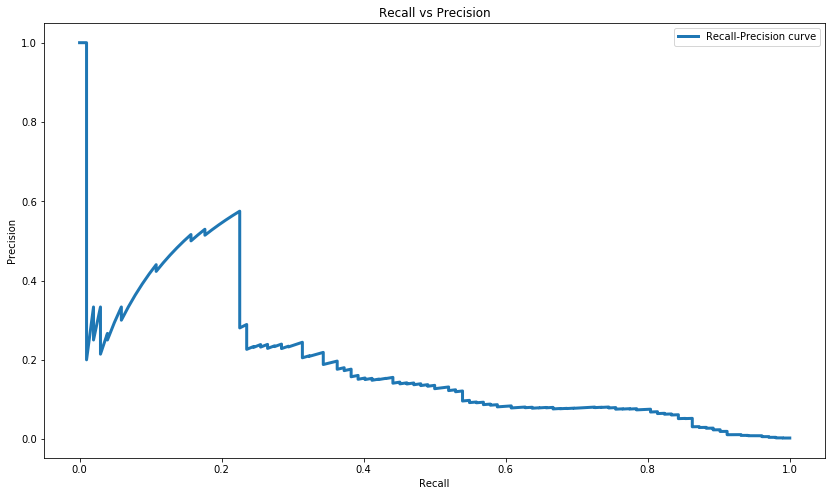

In [62]:
fpr, tpr, threshold = roc_curve(error_df["True_value"], error_df["Reconstruction_error"])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linewidth = 3, color = 'red', label = 'AUC = '% roc_auc)
plt.plot([0,1], [0,1], linewidth = 3, color = 'blue', alpha = 0.6) 

plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.show()


precision, recall, threshold_rp = precision_recall_curve(error_df["True_value"], error_df["Reconstruction_error"])
plt.plot(recall, precision, linewidth = 3, label= 'Recall-Precision curve')
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = 'upper right')
plt.show()


Precision v/s Recall is a tradeoff so need a threshold which is determined as a business decision. In this case, the tradeoff is between missing a fraudulent transaction and falsely flagging a transaction as fraud. To visualize the graphs against threshold, I'll plot recall and precision against the threshold value. 

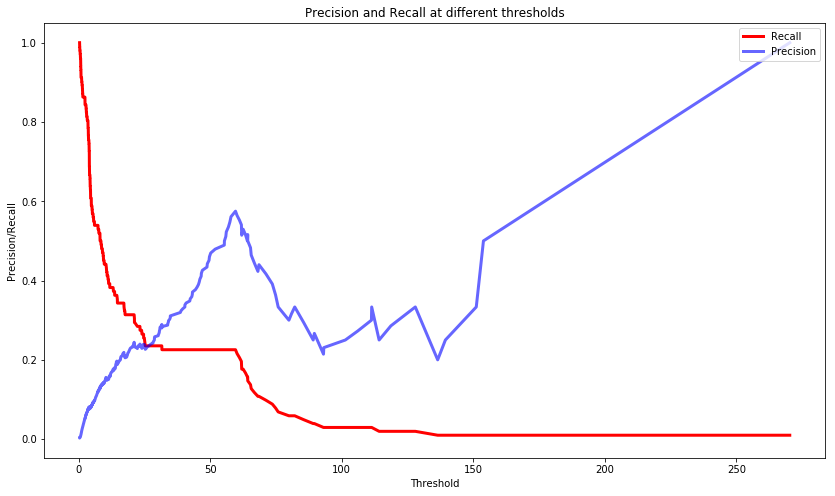

In [65]:
plt.plot(threshold_rp, recall[0:-1], label = 'Recall', linewidth = 3, color = 'red')
plt.plot(threshold_rp, precision[0:-1], label = 'Precision', linewidth = 3, alpha = 0.6, color ='blue')

plt.title("Precision and Recall at different thresholds")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc = 'upper right')
plt.show()

Now that we have the threshold, lets see where the line is drawn and how many fraudulent transactions does it miss. 

In [171]:
fraud_recon = []
fraud_index = []
non_fraud_recon = []
non_fraud_index = []
for i,j in error_df.iterrows():
    if j["True_value"] == 1 :
        fraud_recon.append(j["Reconstruction_error"])
        fraud_index.append(i)
    else:
        non_fraud_recon.append(j["Reconstruction_error"])
        non_fraud_index.append(i)

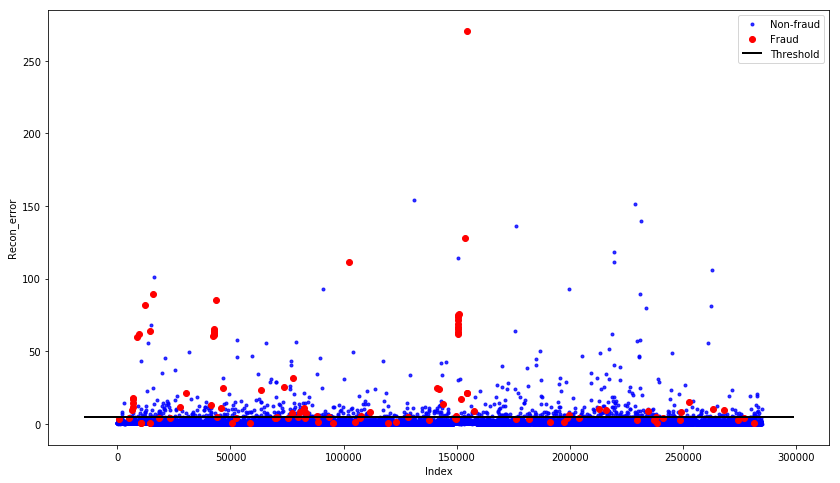

In [189]:
figure = plt.figure() 
ax = figure.add_subplot(111)
ax.scatter(non_fraud_index, non_fraud_recon, marker ='.', color = 'blue', alpha = 0.8, label = 'Non-fraud')
ax.scatter(fraud_index, fraud_recon, marker = 'o', color = 'red', label = 'Fraud')
ax.hlines(5, ax.get_xlim()[0], ax.get_xlim()[1], colors="black", zorder=100, label='Threshold', linewidth = 2)
plt.legend(loc = 'upper right')
plt.xlabel("Index")
plt.ylabel("Recon_error")
plt.show()

The threshold seems to avoid most of the normal transactions while still flagging a lot of the fraudulent transactions. 

To summarize, I attempted to use technology to come up with business solutions for credit card fraud detection problem. I started with some exploratory analysis but when that did not work out, I used a simple autoencoder to detect features of interest and use it for prediction of fraudulent transactions with an accuracy of ~70%. After which I used the model to generate some graphs of business interest and set a threshold to flag transactions